In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from keras_segmentation.pretrained import pspnet_50_ADE_20K
model = pspnet_50_ADE_20K()

In [959]:
img1 = cv2.imread("915966.png", cv2.IMREAD_COLOR) #cracks1
img2 = cv2.imread("915945.png",cv2.IMREAD_COLOR) #cracks2
img3 = cv2.imread("819784.png",cv2.IMREAD_COLOR) #cracks3
img4 = cv2.imread("1007608.png",cv2.IMREAD_COLOR) #cracks4
img11 = cv2.imread("916152.png", cv2.IMREAD_COLOR) #shadow

img5 = cv2.imread("883270.png", cv2.IMREAD_COLOR) #potholes 1
img6 = cv2.imread("883068.png", cv2.IMREAD_COLOR) #potholes 2
img7 = cv2.imread("883083.png", cv2.IMREAD_COLOR) #potholes 3
img8 = cv2.imread("916887.png", cv2.IMREAD_COLOR) #potholes 4
img9 = cv2.imread("917043.png", cv2.IMREAD_COLOR) #potholes 5
img10 = cv2.imread("992866.png", cv2.IMREAD_COLOR) #potholes 6

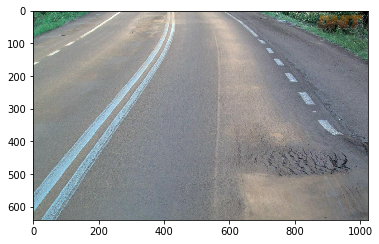

In [1099]:
imgt = img4
plt.imshow(imgt,cmap="gray")

In [1100]:
# pip install keras==2.4.3

In [1101]:
# pip install keras-segmentation

In [1102]:
# pip install tensorflow==2.4.1

# getting the road mask

In [1103]:
re = model.predict_segmentation(
    inp=imgt,
    out_fname="out.jpg"
)

In [1104]:
out1 = cv2.imread("out.jpg")
out1.shape

(640, 1024, 3)

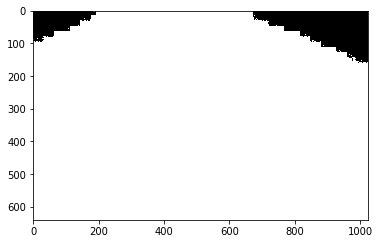

In [1105]:
colours, counts = np.unique(out1.reshape(-1,3), axis=0, return_counts=1)

np.argmax(counts)
#index of xolor of road segment

road = tuple(colours[np.argmax(counts)])
# road (37,168,241)


mask1 = out1.copy()

road_pix = np.all(out1 == road, axis=-1)

non_road_pix = np.any(out1 != road, axis=-1)  

mask1[road_pix] = [255, 255, 255]
mask1[non_road_pix] = [0, 0, 0] 

plt.imshow(mask1, cmap = 'gray')

In [1106]:
mask = mask1.astype('uint8')
mask1 = mask[:,:,0]   #converting to 1 channel

In [1107]:
contours, hierarchy = cv2.findContours(mask1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
hull_list = []
for i in range(len(contours)):
    hull = cv2.convexHull(contours[i])
    hull_list.append(hull)

In [1108]:
fmask1 = mask1.copy()
cv2.drawContours(fmask1, hull_list, -1, (255, 255, 255), -1);
kernel = np.ones((5,5),np.uint8)
fmask1 = cv2.morphologyEx(fmask1, cv2.MORPH_CLOSE, kernel,iterations = 1)
kernel = np.ones((3,3),np.uint8)
fmask1 = cv2.erode(fmask1,kernel,iterations = 40)

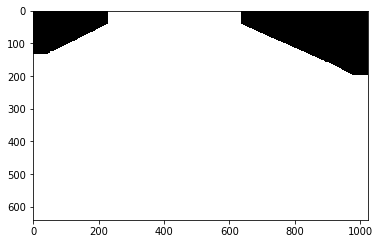

In [1109]:
plt.imshow(fmask1,cmap="gray")

# getting the mask to remove lanes in roads

In [1110]:
#to remove the lanes.
img = cv2.cvtColor(imgt, cv2.COLOR_BGR2GRAY)

ret,thresh1 = cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
kernel = np.ones((3,3),np.uint8)

closing = cv2.morphologyEx(thresh1, cv2.MORPH_CLOSE, kernel,iterations = 2)
erosion = cv2.erode(closing,kernel,iterations = 10)
mask2 = erosion

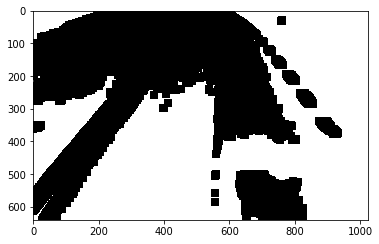

In [1111]:
fmask1.shape
mask = cv2.bitwise_and(fmask1,fmask1,mask=mask2)

plt.imshow(mask2,cmap="gray")

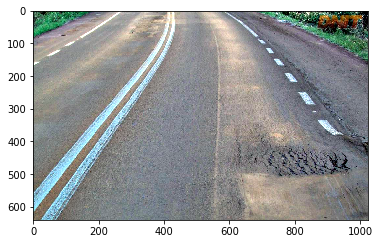

In [1112]:
g_blur = cv2.GaussianBlur(imgt,(251,251),0)
sharp = cv2.addWeighted(imgt, 2.0, g_blur, -1.0, 0) #better image than the actual gray scale interms of crack visibility.
plt.imshow(sharp,cmap="gray")

# algorithm 1

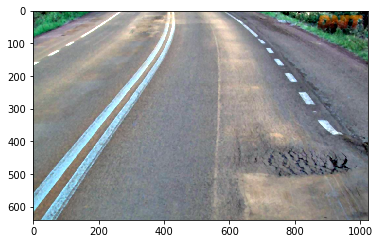

In [1113]:
#algorithm 1
fil = cv2.medianBlur(sharp,5) 
plt.imshow(fil,cmap="gray")

In [1114]:
img = cv2.cvtColor(fil, cv2.COLOR_BGR2GRAY)

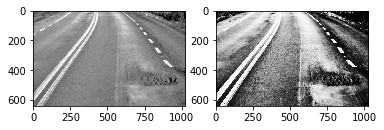

In [1115]:
image_eq = cv2.equalizeHist(img)
cmap_val = 'gray'

plt.subplot(1,2,1)
plt.imshow(img,cmap="gray")
plt.subplot(1,2,2)
plt.imshow(image_eq,cmap="gray")

In [1116]:
#filtering to reduce the noise
image_eq = cv2.bilateralFilter(image_eq,9,25,75)
image_eq = cv2.GaussianBlur(image_eq,(3,3),0)

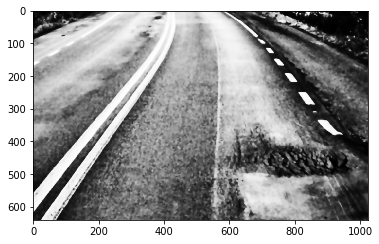

In [1117]:
plt.imshow(image_eq,cmap="gray")
plt.show()

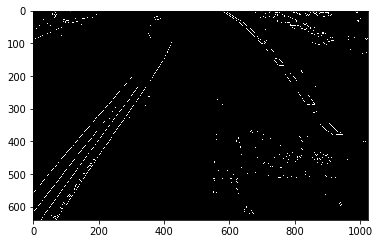

In [1118]:
# image = cv2.cvtColor(image_eq, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(image_eq,250,250,apertureSize = 3, L2gradient = True)
plt.imshow(edges,cmap="gray")
plt.show()

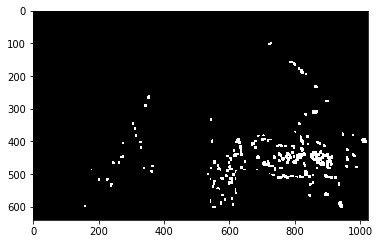

In [1119]:
kernel = np.ones((3,3),np.uint8)
binary1 = cv2.dilate(edges,kernel,iterations = 3)
binary1 = cv2.morphologyEx(binary1, cv2.MORPH_OPEN, kernel,iterations = 3)
binary1 = np.multiply((mask),binary1)
plt.imshow(binary1,cmap="gray") 
plt.show()

# function to find the contours

In [1120]:
def contour(imgb,imgt):
    
    contours,_= cv2.findContours(imgb, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    temp = imgt.copy()
    thr = []

# trial before deciding the final code.
#     for i in contours:
#         ar = cv2.contourArea(i)
#         if(ar > 800) and cv2.contourArea(i) > cv2.arcLength(i, True):
#             rect = cv2.boundingRect(i)
#             x,y,w,h = rect
#             rect_area = w*h
#             extent = float(ar)/rect_area

#             clr = ()
#             if extent<0.2 and cv2.arcLength(i, True) in range(int(ar) - 100,int(ar)+100):
#                  #cracks 
#                 clr = (0,0,255)
# #                 else:
# #                     continue
#             elif extent > 0.3:          #pothole and (cv2.arcLength(i, True)>(2.5*(w+h)//2))
#                 if(ar > 1000):
#                     clr = (0,255,0)
#                 else:
#                     continue
#             else:
#                 continue
#             cv2.rectangle(temp,(x,y),(x+w,y+h),clr,2)
#             thr.append(i)
    for i in contours:
        ar = cv2.contourArea(i)
        if(ar > 500) and cv2.contourArea(i) > cv2.arcLength(i, True):
            rect = cv2.boundingRect(i)
            x,y,w,h = rect
            rect_area = w*h
            extent = float(ar)/rect_area

            if(extent > 0.2 and extent < 0.4):  #nothin 
                continue
            else:          #pothole and crack
                if(ar > 1000):
                    clr = (0,255,0)
                else:
                    continue
            cv2.rectangle(temp,(x,y),(x+w,y+h),clr,2)
            thr.append(i)
#     cv2.drawContours(temp, thr, -1, (255,0,0), thickness=cv2.FILLED)  
    plt.imshow(temp,cmap="gray")
    plt.show()
    
    return temp

# algorithm 2

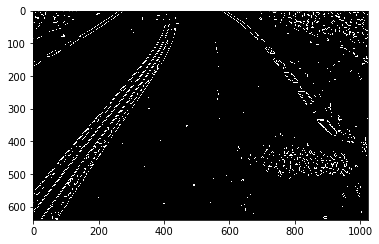

In [1121]:
#algorithm 2
gray = cv2.cvtColor(sharp,cv2.COLOR_BGR2GRAY)

gray = cv2.GaussianBlur(gray,(5,5),0)

#sobel filter
x = cv2.Sobel(gray, cv2.CV_16S, 1, 0, ksize=3) #sobel along x direction
y = cv2.Sobel(gray, cv2.CV_16S, 0, 1, ksize=3) #sobel along y direction

abs_x = cv2.convertScaleAbs(x) #absolute value of gradient x
abs_y = cv2.convertScaleAbs(y) #absolute value of gradient y
gradient = cv2.addWeighted(abs_x, 0.5, abs_y, 0.5, 0)

kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(gradient,cv2.MORPH_CLOSE,kernel, iterations = 3)

edges2 = cv2.Canny(opening,100,150,apertureSize = 3, L2gradient = True)
plt.imshow(edges2,cmap="gray")
plt.show()

In [1122]:
binary2 = np.multiply((mask),edges2)

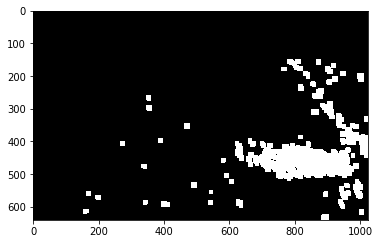

In [1123]:
kernel = np.ones((5,5),np.uint8)
dil = cv2.dilate(binary2,kernel,iterations = 3)
kernel2 = np.ones((3,3),np.uint8)
er = cv2.erode(dil,kernel2,iterations = 5)
op = cv2.morphologyEx(er,cv2.MORPH_CLOSE,kernel, iterations = 3) #2nd algorithm result.
plt.imshow(dil,cmap="gray")
plt.show()

# calling the contour function twice (once for each algorithm) to get the final image

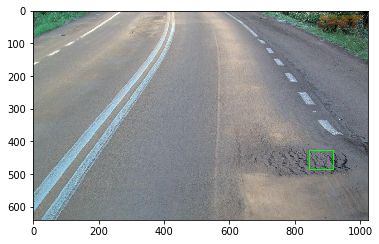

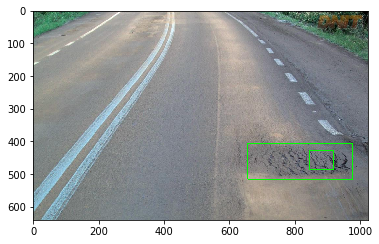

In [1124]:
# contours,im2 = cv2.findContours(op, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
out1 = contour(binary1,imgt)
out2 = contour(op,out1) 

#out2 is the final output containg the union of the results of both the algorithms

In [1125]:
# cv2.imwrite("992866_fin.png",out2)